In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import pickle
import matplotlib.pyplot as plt
import time
import datetime
import re
from sklearn.preprocessing import MultiLabelBinarizer


movielibrary = pickle.load(open("With_IMDB.p", "rb"))
#Some movies have been identified as 'bad' during processing. These are loaded now, as a list. 
movies_to_skip = pickle.load(open("Movies to skip.p", "rb"))

In [2]:
len(movielibrary)

5209

# Retrieve information from Box Office Mojo weekly table

Reads in values from Box Office Mojo weekly table into a dataframe, and saves that dataframe as Weeklies_BoxOfficeMojo_df.p. 
Name was used as an index as I originally drew from the movies each year; it later was found to be inaccurate to the actual name of the movie, but perfectly functional as an indexing tool. 

In [3]:
cols = ["REAL name", "index_Name","Date", "Rank", "Weekly", "%LW", "Theaters", "Change", "Avg", "To Date", "Week", "Estimated"]

table = []
for movie in list(movielibrary.keys()):
    if movie not in movies_to_skip:
        #First, extract the B.Soup of the page. Then, obtain a
        page = BeautifulSoup(movielibrary[movie]["Domestic Weekly"], "lxml")
        main_table = page.find("table")
        
        #The movie name was originally determined by clicking on a link with the name in the Name column.
        #Now, grab the page title to determine what it actually is- "REAL name"
        
        title = page.find("h1", class_="a-size-extra-large").text
        if main_table!=None:        
            for row in main_table.find_all("tr")[1:]:
                newrow = [title, movie]
                
                for item in row.find_all("td"):
                    newrow.append(item.text)
                table.append(newrow)
        else:
            movies_to_skip.add(movie)
        
weeklies_df= pd.DataFrame(data = table, columns =cols)
pickle.dump(movies_to_skip, open("Movies to skip.p", "wb"))

In [4]:
weeklies_df[weeklies_df["index_Name"]!=weeklies_df["REAL name"]]

,REAL name,index_Name,Date,Rank,Weekly,%LW,Theaters,Change,Avg,To Date,Week,Estimated
1939,Arctic,Arctic2019 Re-release,Feb 1-7,44,"$66,908",-,4,-,"$16,727","$66,908",1,false
1940,Arctic,Arctic2019 Re-release,Feb 8-14,48,"$121,676",+81.9%,15,+11,"$8,111","$188,584",2,false
1941,Arctic,Arctic2019 Re-release,Feb 15-21,35,"$365,221",+200.2%,15,-,"$24,348","$553,805",3,false
1942,Arctic,Arctic2019 Re-release,Feb 22-28,24,"$713,704",+95.4%,257,+242,"$2,777","$1,267,509",4,false
1943,Arctic,Arctic2019 Re-release,Mar 1-7,27,"$535,988",-24.9%,268,+11,"$1,999","$1,803,496",5,false
...,...,...,...,...,...,...,...,...,...,...,...,...
40718,Syrup,Remnants,Jun 14-20,112,$285,-24.6%,1,-,$285,$663,2,false
40719,Hammer of the Gods,Billy and Buddy,Jul 5-11,104,$191,-,2,-,$95,$191,1,false
40720,Hammer of the Gods,Billy and Buddy,Jul 12-18,115,$450,+135.6%,2,-,$225,$641,2,false
40721,Triumph of the Wall,I Spit on Your Grave 2,May 31-Jun 6,115,$476,-,1,-,$476,$476,1,false


In [5]:
df_fixed_lines = weeklies_df.copy()

#First, processing the weekly values.

#Convert the "Average" column, holding per-threater weekly take, by converting it into an integer value.
df_fixed_lines["Avg"] = df_fixed_lines["Avg"].apply(lambda x: int(x.replace(",", "").replace("$", "").replace("-", "1")))

#Deal with cases where a movie was shown for only one week.
df_fixed_lines["Week"] = df_fixed_lines["Week"].apply(lambda x: int(x.replace("-", "1")))

#Determine 'peak' weekly per-theater value.
for_max_value = df_fixed_lines.rename(columns={"Avg": "Peak"}).groupby(["index_Name"])[["index_Name", "Peak"]].max().reset_index(drop=True).merge(df_fixed_lines)

#Identify how long a movie was shown since its initial date.
for_max_value = for_max_value.merge(for_max_value.rename(columns = {"Week":"In Theaters"}).groupby("index_Name")["In Theaters"].max().reset_index())
#Identify how many weeks of data we have- if this is different from "In Theaters", we have gaps. 
for_max_value = for_max_value.merge(for_max_value.rename(columns = {"Week":"Weeks of Data"}).groupby("index_Name")["Weeks of Data"].count().reset_index())
for_max_value

,index_Name,Peak,REAL name,Date,Rank,Weekly,%LW,Theaters,Change,Avg,To Date,Week,Estimated,In Theaters,Weeks of Data
0,'71,6392,Beyond the Mask,Apr 3-9,19,"$441,755",-,86,-,5136,"$441,754",1,false,20,20
1,'71,6392,Beyond the Mask,Apr 10-16,30,"$140,385",-68.2%,39,-47,3599,"$582,139",2,false,20,20
2,'71,6392,Beyond the Mask,Apr 17-23,37,"$70,291",-49.9%,21,-18,3347,"$652,431",3,false,20,20
3,'71,6392,Beyond the Mask,Apr 24-30,57,"$31,634",-55%,5,-16,6326,"$684,065",4,false,20,20
4,'71,6392,Beyond the Mask,May 1-7,57,"$19,178",-39.4%,3,-2,6392,"$703,243",5,false,20,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40718,Évocateur: The Morton Downey Jr. Movie,4511,The Painting,May 17-23,100,"$2,451",-45.7%,1,-,2451,"$6,962",2,false,4,4
40719,Évocateur: The Morton Downey Jr. Movie,4511,The Painting,May 24-30,68,"$13,721",+459.8%,6,+5,2286,"$20,683",3,false,4,4
40720,Évocateur: The Morton Downey Jr. Movie,4511,The Painting,May 31-Jun 6,118,$325,-97.6%,1,-5,325,"$21,008",4,false,4,4
40721,Évolution,1027,Sudden Fear,Aug 12-18,61,"$18,498",-,18,-,1027,"$18,498",1,false,2,2


In [6]:
# # A number of values I examined using as metrics for decay rate. Deprecated. 

# for_max_value["Decay to-date"] = for_max_value["Avg"]/for_max_value["Peak"]
# for_max_value["Log Decay"] = np.log(for_max_value["Decay to-date"])
# for_max_value["Log Week"] = np.log(for_max_value["Week"])
# for_max_value["Log Decay as weekly"] = for_max_value["Log Decay"]/(for_max_value["Week"])
# for_max_value["Decay inverse"] = (for_max_value["Decay to-date"])*(for_max_value["Week"])
# for_max_value["Complete Data"]= (for_max_value["In Theaters"]==for_max_value["Weeks of Data"])

In [7]:
def to_week_number(item):
    '''Converts a week of the form 'May 31-Jun 6' to a week number of the year.'''
    item=item.split("-")[0]
    month, day= item.split(" ")
    if len(day)==1:
        day = " "+day
    return datetime.datetime.strptime(month+day, "%b%d").isocalendar()[1]
for_max_value["Week_of_Year"] = for_max_value["Date"].apply(to_week_number)

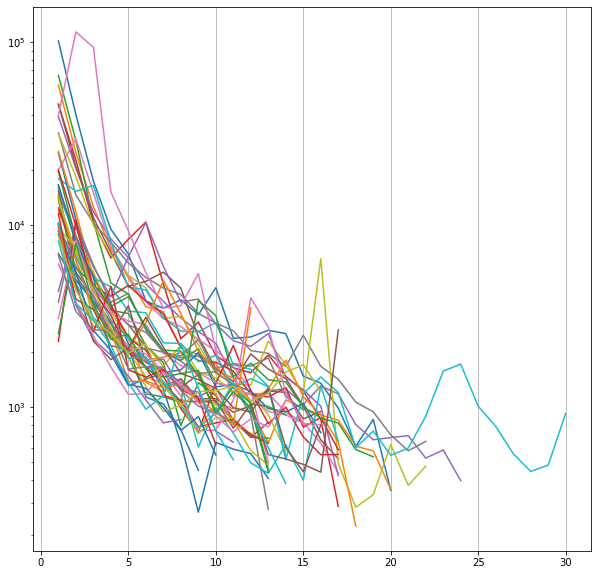

In [8]:
#Plotting for reference: Decay rate as a function of time, as compared to the peak box office per-theater.
plt.figure(figsize=(10, 10))
plt.yscale("log")
for name in list(movielibrary.keys())[0:50]:
    movieselector = for_max_value[for_max_value["index_Name"]==name]
    plt.plot(movieselector["Week"], movieselector["Avg"])
plt.grid(axis="x")

In [9]:
pickle.dump(for_max_value, open("Weeklies_BoxOfficeMojo_df.p", "wb"))

# Retrieve information from Box Office Mojo summary page

Functions similarly to the IMDB reader. Extracts key metrics into "BoxOfficeMojo_df.p".

In [2]:
summary_values = []
cols = ["index_Name", "Budget", "MPAA", "Genres", "Domestic Opening", "Running Time"]

set_of_MPAAs= set({})
set_of_genres = set({})
movies_to_skip = pickle.load(open("Movies to skip.p", "rb"))
for movie in list(movielibrary.keys()):
    if "BOM Summary" in movielibrary[movie]:
        main_table = BeautifulSoup(movielibrary[movie]["BOM Summary"], "lxml").find(class_="a-section a-spacing-none mojo-summary-values mojo-hidden-from-mobile")
        if main_table!=None:        
            name = movie
            divs = main_table.find_all("div")
            
            budget_ = main_table.find(text="Budget")
            if budget_ !=None:
                budget = budget_.findNext().text
            else:
                budget = None
            
            mpaa_ = main_table.find(text="MPAA")
            if mpaa_ != None: 
                mpaa = mpaa_.findNext().text
                set_of_MPAAs.add(mpaa)
            else: 
                mpaa=None
                
            genres_ = main_table.find(text="Genres")
            if genres_ !=None:
                genres = set(re.split(" |\n", genres_.findNext().text))
                set_of_genres.update(genres)
            else:
                genres = set({})
                
                
            runtime_ = main_table.find(text="Running Time")
            if runtime_ !=None:
                runtime = runtime_.findNext().text
            else:
                runtime = None
            
            opening_ = main_table.find(text="Opening")
            if opening_ !=None:
                opening = opening.findNext().text
            else:
                opening = None
            
            summary_values.append([name, budget, mpaa, genres, opening, runtime])
            
        else:
            print(movie)
            movies_to_skip.add(movie)
    else:
        print(movie)
        movies_to_skip.add(movie)
movie_attributes= pd.DataFrame(data=summary_values, columns=cols)
print(set_of_MPAAs)
print(set_of_genres)
pickle.dump(movies_to_skip, open("Movies to skip.p", "wb"))

Friendsgiving Day #1
Friendsgiving Day #2
Doctor Who: Logopolis
Fritz Lang's Indian Epic2019 re-release
Jim Henson's Holiday Special with Fraggle Rock and Emmet Otter
The Walking Dead: Wrath/The Walking Dead/Fear the Walking Dead: What's Your Story?/Fear the Walking Dead2018 NCM Fathom Event
Dragon Ball Z: Bardock - The Father of Goku/Dragon Ball Z: Fusion Reborn
Sailor Moon R: The Movie: The Promise of the Rose/Sailor Moon S: The Movie - Hearts in IceDouble Bill
Cobra Kai Premiere Event feat. The Karate Kid2018 NCM Fathom Event
Jumanji/Jumanji: Welcome to the Jungle2018 NCM Fathom Event
A Bread Factory, Part One/A Bread Factory, Part Two
Disney Junior HalloVeen Party!
Marius/Fanny/César
Billy Lynn's Long Halftime Walk
Old Fashioned
Son of Saul
Badlapur
Tap World
Some Velvet Morning
{'NC-17', 'PG', 'M/PG', 'R', 'PG-13', 'TV-PG', 'G', 'Not Rated'}
{'', 'Adult', 'Drama', 'Sport', 'Comedy', 'Animation', 'Adventure', 'Romance', 'Sci-Fi', 'Music', 'Western', 'Musical', 'History', 'Reality-T

In [4]:
#Use the MLB to dummy out the genre.
mlb = MultiLabelBinarizer()
genres = list(list(zip(*summary_values))[3])
vals = mlb.fit_transform(genres)
cols = mlb.classes_
movie_genres = pd.DataFrame(data=vals, columns=cols)
movies_and_genres = movie_attributes.reset_index().merge(movie_genres.reset_index())

#Because MPAA rating is a single 
for rating in set_of_genres:
    movies_and_genres[rating] = movies_and_genres["MPAA"]==rating

In [16]:
pickle.dump(movies_and_genres, open("BoxOfficeMojo_df.p", "wb"))